Clean data

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('../data.csv')

In [5]:
df.isnull().sum()
df.fillna(method='ffill', inplace=True)

C:\Users\tosca\AppData\Local\Temp\ipykernel_9048\2903114193.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


Encoder

In [6]:
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from category_encoders import TargetEncoder

In [7]:
le_sex = LabelEncoder()
df['sex'] = le_sex.fit_transform(df['sex'])

ordinal_encoder = OrdinalEncoder(categories=[['Incomplete secondary education', 'Secondary education', 'Secondary special education','Incomplete higher education', 'Higher education', 'PhD degree']]) 
df['education'] = ordinal_encoder.fit_transform(df[['education']])

target_encoder = TargetEncoder(cols=['product_type', 'family_status'], smoothing=1.0)
df[['product_type', 'family_status']] = target_encoder.fit_transform(df[['product_type', 'family_status']], df['bad_client_target'])

df.head()

,month,credit_amount,credit_term (month),age,sex,education,product_type,having_children_flg,region,income,family_status,phone_operator,is_client,bad_client_target
0,1,7000,12,39,1,2.0,0.226908,0,2,21000,0.104080,0,0,0
1,1,19000,6,20,1,2.0,0.076433,1,2,17000,0.104080,3,1,0
2,1,29000,12,23,0,2.0,0.076433,0,2,31000,0.104080,2,0,0
3,1,10000,12,30,1,2.0,0.226908,1,2,31000,0.115385,3,1,0
4,1,14500,12,25,0,4.0,0.226908,0,2,26000,0.139640,0,1,0


Verification de colinéarité

In [8]:
import numpy as np

correlation_matrix = df.corr()
for i in range(correlation_matrix.shape[0]):
    for j in range(correlation_matrix.shape[1]):
        if (correlation_matrix.iloc[i, j] == 1 or correlation_matrix.iloc[i, j] == -1) and i != j :
                print(f"Correlation of 1 or -1 found between '{correlation_matrix.index[i]}' and '{correlation_matrix.columns[j]}'")

Data set

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

In [10]:
X = df.drop(columns=['bad_client_target']) # Region and phone op are useless data but better benchmark with 
y = df['bad_client_target'] 

In [11]:
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) #divide dataset 80/20

Standardisation

In [12]:
scaler = StandardScaler() 
X_train_scaled = scaler.fit_transform(X_train)  # Normalisation des données, (x-µ)/σ où : x = data, µ = moyenne de la colonne, σ = ecart-type de la colonne
X_test_scaled = scaler.transform(X_test)        # Donnée normalisé = même echelle = pas de donnée avec plus de poid

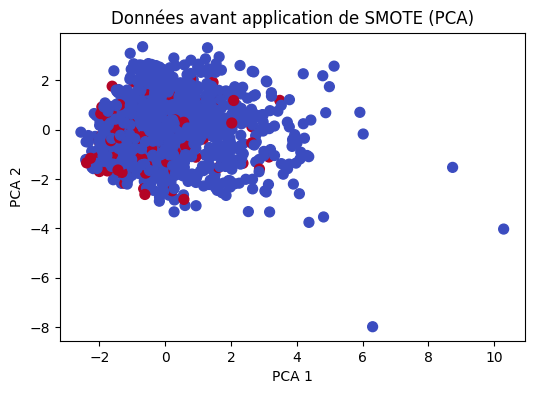

In [13]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)

# Visualiser les données avant rééchantillonnage
plt.figure(figsize=(6, 4))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='coolwarm', s=50)
plt.title("Données avant application de SMOTE (PCA)")
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

In [14]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (1378, 13)
y_train shape: (1378,)
X_test shape: (345, 13)
y_test shape: (345,)


Echantillonage des classes

In [15]:
from imblearn.over_sampling import SMOTE

In [16]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

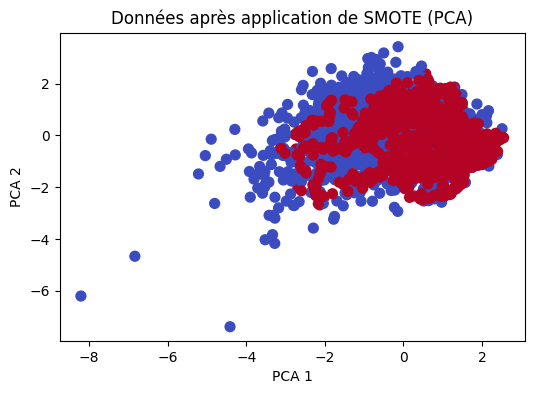

In [17]:
X_train_resampled_pca = pca.fit_transform(X_train_resampled)

# Visualiser les données rééchantillonnées après réduction de dimension
plt.figure(figsize=(6, 4))
plt.scatter(X_train_resampled_pca[:, 0], X_train_resampled_pca[:, 1], c=y_train_resampled, cmap='coolwarm', s=50)
plt.title("Données après application de SMOTE (PCA)")
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

Modèle

In [24]:
#ATTENTION INES SI TU EXEC CETTE CEL, ca te prendra bien 5 min

from sklearn.ensemble import RandomForestClassifier


# Listes d'hyperparamètres à tester
n_estimators_list = [100, 200, 300]  # nombre d'arbres
max_depth_list = [10, 20, 30]  # profondeur maximale des arbres
min_samples_split_list = [2, 5, 10]  # minimum de samples pour split
min_samples_leaf_list = [1, 2, 4]  # minimum de samples par feuille
max_features_list = ['sqrt', 'log2', None]  # nombre de features à considérer

# Variable pour stocker les meilleurs paramètres et le score maximal
best_params = None
best_score = 0

# Boucle pour tester toutes les combinaisons d'hyperparamètres
for n_estimators in n_estimators_list:
    for max_depth in max_depth_list:
        for min_samples_split in min_samples_split_list:
            for min_samples_leaf in min_samples_leaf_list:
                for max_features in max_features_list:
                    # Initialiser et entraîner le modèle
                    clf = RandomForestClassifier(
                        class_weight='balanced',
                        n_estimators=n_estimators,
                        max_depth=max_depth,
                        min_samples_split=min_samples_split,
                        min_samples_leaf=min_samples_leaf,
                        max_features=max_features,
                        random_state=42
                    )
                    clf.fit(X_train_resampled, y_train_resampled)
                    
                    # Prédire sur l'ensemble de test
                    y_pred = clf.predict(X_test_scaled)
                    
                    # Calculer la précision
                    score = accuracy_score(y_test, y_pred)
                    
                    # Si ce score est meilleur, on met à jour les meilleurs paramètres
                    if score > best_score:
                        best_score = score
                        best_params = {
                            'n_estimators': n_estimators,
                            'max_depth': max_depth,
                            'min_samples_split': min_samples_split,
                            'min_samples_leaf': min_samples_leaf,
                            'max_features': max_features
                        }

# Afficher les meilleurs paramètres et le meilleur score
print(f"Meilleurs paramètres : {best_params}")
print(f"Meilleur score : {best_score}")


Meilleurs paramètres : {'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt'}
Meilleur score : 0.8463768115942029


Sans équilibrage des classes :
Meilleurs paramètres : {'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt'}
Meilleur score : 0.8463768115942029

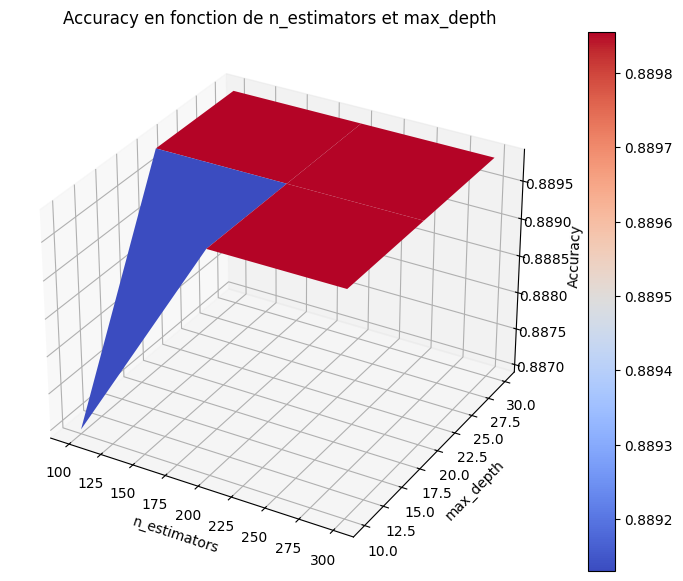

In [19]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# Générer les résultats pour une grille 3D d'hyperparamètres
n_estimators_list = [100, 200, 300]
max_depth_list = [10, 20, 30]
min_samples_split_list = [2, 5, 10]

# Stocker les scores
scores = np.zeros((len(n_estimators_list), len(max_depth_list), len(min_samples_split_list)))

for i, n_estimators in enumerate(n_estimators_list):
    for j, max_depth in enumerate(max_depth_list):
        for k, min_samples_split in enumerate(min_samples_split_list):
            clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, random_state=42)
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            scores[i, j, k] = accuracy_score(y_test, y_pred)

# Surface 3D pour visualiser l'influence de 2 hyperparamètres (n_estimators et max_depth)
X, Y = np.meshgrid(n_estimators_list, max_depth_list)
Z = scores[:, :, 0]  # Fixer min_samples_split = 2 pour visualisation

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm)
ax.set_xlabel('n_estimators')
ax.set_ylabel('max_depth')
ax.set_zlabel('Accuracy')

plt.title("Accuracy en fonction de n_estimators et max_depth")
fig.colorbar(surf)
plt.show()


In [20]:
random_forest = RandomForestClassifier(n_estimators= 100, max_depth= 20, min_samples_split= 2, min_samples_leaf= 2, max_features= 'sqrt', class_weight='balanced')
random_forest.fit(X_train_resampled, y_train_resampled)
y_pred_random_forest = random_forest.predict(X_test_scaled)

In [21]:
# 2. Calculer la précision
accuracy = accuracy_score(y_test, y_pred_random_forest)
print(f'Précision : {accuracy:.2f}')

# 3. Générer un rapport de classification
report = classification_report(y_test, y_pred_random_forest)
print('Rapport de classification :\n', report)

Précision : 0.83
Rapport de classification :
               precision    recall  f1-score   support

           0       0.91      0.90      0.90       306
           1       0.28      0.31      0.29        39

    accuracy                           0.83       345
   macro avg       0.59      0.60      0.60       345
weighted avg       0.84      0.83      0.84       345



<function matplotlib.pyplot.show(close=None, block=None)>

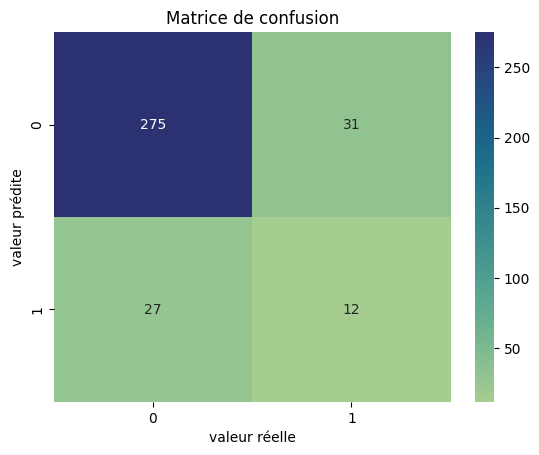

In [22]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test, y_pred_random_forest)
sns.heatmap(conf_matrix,annot=True, fmt='d', cmap='crest')
plt.title("Matrice de confusion")
plt.xlabel("valeur réelle")
plt.ylabel("valeur prédite")
plt.show